#  LSTM? — It's purpose-built for sequence data like text. It captures word order and context, making it ideal for sentiment classification. A Bidirectional LSTM reads text in both directions for even better understanding

In [86]:
# importing models 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [87]:
# ================================================= EDA =================================================

In [88]:
dataset  = pd.read_csv('../datasets/amazon.csv')
dataset.head()
dataset.info()
dataset.shape
dataset.describe()

<class 'pandas.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4915 non-null   int64  
 1   reviewerName          4914 non-null   str    
 2   overall               4915 non-null   int64  
 3   reviewText            4914 non-null   str    
 4   reviewTime            4915 non-null   str    
 5   day_diff              4915 non-null   int64  
 6   helpful_yes           4915 non-null   int64  
 7   helpful_no            4915 non-null   int64  
 8   total_vote            4915 non-null   int64  
 9   score_pos_neg_diff    4915 non-null   int64  
 10  score_average_rating  4915 non-null   float64
 11  wilson_lower_bound    4915 non-null   float64
dtypes: float64(2), int64(7), str(3)
memory usage: 460.9 KB


,Unnamed: 0,overall,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
count,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000
mean,2457.000000,4.587589,437.367040,1.311089,0.210376,1.521465,1.100712,0.075468,0.020053
std,1418.982617,0.996845,209.439871,41.619161,4.023296,44.123095,39.367949,0.256062,0.077187
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-130.000000,0.000000,0.000000
25%,1228.500000,5.000000,281.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2457.000000,5.000000,431.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3685.500000,5.000000,601.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4914.000000,5.000000,1064.000000,1952.000000,183.000000,2020.000000,1884.000000,1.000000,0.957544


In [89]:
# printing all the columns in the dataset
print(dataset.columns)

Index(['Unnamed: 0', 'reviewerName', 'overall', 'reviewText', 'reviewTime',
       'day_diff', 'helpful_yes', 'helpful_no', 'total_vote',
       'score_pos_neg_diff', 'score_average_rating', 'wilson_lower_bound'],
      dtype='str')


In [90]:
# removing unwanted columns 
dataset  = dataset.drop(["Unnamed: 0","reviewerName","reviewTime"],axis=1,inplace=False)

In [91]:
dataset.columns

Index(['overall', 'reviewText', 'day_diff', 'helpful_yes', 'helpful_no',
       'total_vote', 'score_pos_neg_diff', 'score_average_rating',
       'wilson_lower_bound'],
      dtype='str')

In [92]:
# checking for null values 
dataset.isnull().sum()

overall                 0
reviewText              1
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64

In [93]:
# since reviewText has 1 null value, we will drop that row
dataset = dataset.dropna(subset=["reviewText"])

In [94]:
dataset.isnull().sum()

overall                 0
reviewText              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64

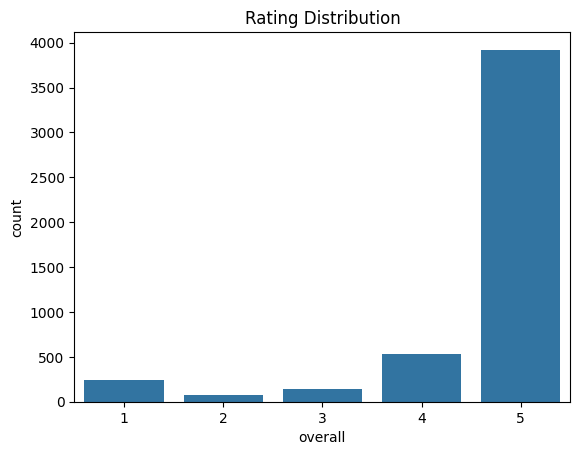

In [95]:
# examining the rating distribution 
sns.countplot(x="overall",data=dataset)
plt.title("Rating Distribution")
plt.show()

In [96]:
# so i got to know dataset is imbalances and most of reviews are 5 star reviews 
# so the dataset is biased towards the positive sentiment 
# solition : 
# 1. class weighting
# 2. oversampling the minority class
# 3. undersampling the majority class



In [97]:
# sentiment distribution labeling 

def map_sentiment(rating):
    if rating >= 4:
        return "positive"
    elif rating == 3:
        return "neutral"
    else:
        return "negative"
    
dataset["sentiment"] = dataset["overall"].apply(map_sentiment)
print(dataset["sentiment"].value_counts())


sentiment
positive    4448
negative     324
neutral      142
Name: count, dtype: int64


C:\Users\Anirban\AppData\Local\Temp\ipykernel_9940\476116905.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=colors)


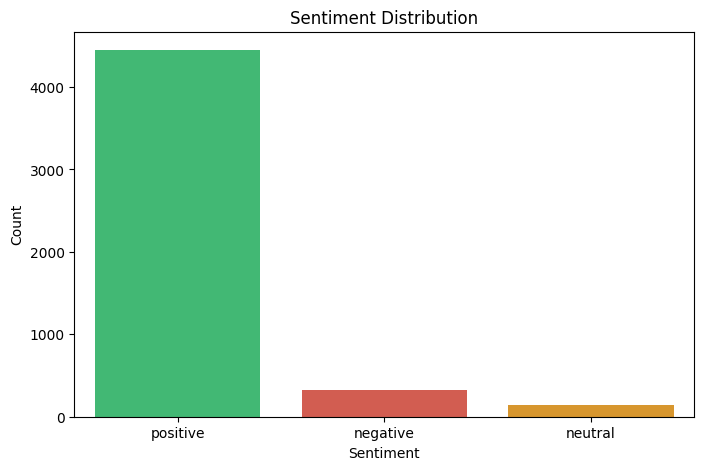

In [98]:
# since the dataset is imbalanced, we will use class weighting to handle the imbalance
# we are going to see the distribution of sentiments in the dataset
plt.figure(figsize=(8, 5))
sentiment_counts = dataset["sentiment"].value_counts()
colors = ["#2ecc71", "#e74c3c", "#f39c12"]
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=colors)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [99]:
# Review Length Analysis
dataset["review_length"] = dataset["reviewText"].apply(lambda x: len(x.split()))
print("Review Length Statistics:")
print(dataset.groupby("sentiment")["review_length"].describe().round(2))

Review Length Statistics:
            count    mean     std  min   25%   50%    75%     max
sentiment                                                        
negative    324.0  106.48  133.85  4.0  43.0  78.0  120.0  1554.0
neutral     142.0   73.25   71.26  7.0  30.0  50.0   94.0   580.0
positive   4448.0   45.64   46.15  1.0  23.0  31.0   50.0  1037.0


C:\Users\Anirban\AppData\Local\Temp\ipykernel_9940\2581496646.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=dataset, x="sentiment", y="review_length",


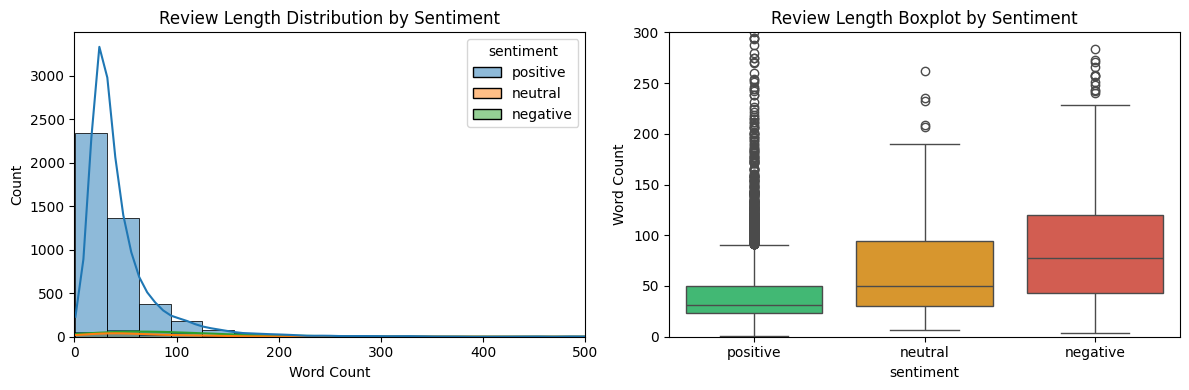

In [100]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(data=dataset, x="review_length", hue="sentiment", bins=50, kde=True)
plt.xlim(0, 500)
plt.title("Review Length Distribution by Sentiment")
plt.xlabel("Word Count")

plt.subplot(1, 2, 2)
sns.boxplot(data=dataset, x="sentiment", y="review_length",
order=["positive", "neutral", "negative"],
palette=["#2ecc71", "#f39c12", "#e74c3c"])
plt.ylim(0, 300)
plt.title("Review Length Boxplot by Sentiment")
plt.ylabel("Word Count")

plt.tight_layout()
plt.show()

In [101]:
# what i figured out most ppls write short reviews and length mostly btn 0-60 words 
# 2nd plot is for mean and dots are outliers 
# distribution is skewed towards short reviews and there are some outliers with very long reviews


In [102]:
### Most common words in each sentiment category

In [103]:
from sklearn.feature_extraction.text import CountVectorizer as CV
vectorizer = CV(stop_words="english",max_features=35)
x = vectorizer.fit_transform(dataset["reviewText"])
print(vectorizer.get_feature_names_out())

['10' 'adapter' 'bought' 'camera' 'card' 'cards' 'class' 'fast' 'galaxy'
 'gb' 'good' 'got' 'great' 'just' 'like' 'memory' 'micro' 'music' 'note'
 'phone' 'price' 'problems' 'product' 'samsung' 'sandisk' 'sd' 'space'
 'speed' 'storage' 'tablet' 'use' 'using' 've' 'work' 'works']


In [104]:
positive_reviews = dataset[dataset["sentiment"]=="positive"]["reviewText"]
negative_reviews = dataset[dataset["sentiment"]=="negative"]["reviewText"]

In [105]:
vectorizer = CV(stop_words="english", max_features=20)

pos_words = vectorizer.fit_transform(positive_reviews)
print("Positive words:", vectorizer.get_feature_names_out())

neg_words = vectorizer.fit_transform(negative_reviews)
print("Negative words:", vectorizer.get_feature_names_out())

Positive words: ['bought' 'card' 'cards' 'fast' 'galaxy' 'good' 'great' 'just' 'memory'
 'music' 'phone' 'price' 'samsung' 'sandisk' 'sd' 'speed' 'storage'
 'tablet' 'use' 'works']
Negative words: ['10' 'amazon' 'bought' 'card' 'cards' 'class' 'data' 'format' 'galaxy'
 'got' 'just' 'memory' 'months' 'phone' 'problem' 'read' 'samsung'
 'sandisk' 'sd' 'tried']


In [106]:
!pip install wordcloud

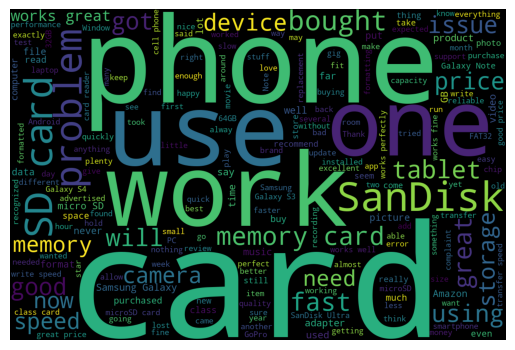

In [107]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(dataset["reviewText"])

wordcloud = WordCloud(width=1200, height=800).generate(text)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

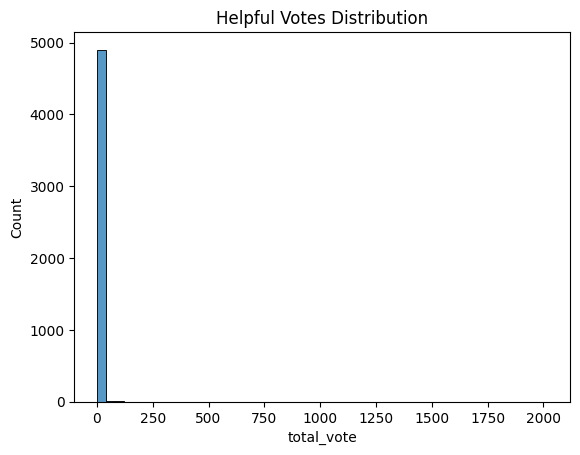

In [108]:
sns.histplot(data=dataset, x="total_vote", bins=50)
plt.title("Helpful Votes Distribution")
plt.show()

In [109]:
# text preprocessing (cleaning the text data)
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z ]", "", text)
    return text

dataset["clean_text"] = dataset["reviewText"].apply(clean_text)

In [110]:
vectorizer = CV(stop_words="english", ngram_range=(2,2), max_features=20)

bigrams = vectorizer.fit_transform(dataset["clean_text"])
print(vectorizer.get_feature_names_out())

['card phone' 'card reader' 'card works' 'galaxy note' 'galaxy tab'
 'gb card' 'good price' 'gopro hero' 'great price' 'memory card'
 'memory cards' 'micro sd' 'microsd card' 'samsung galaxy' 'sandisk ultra'
 'sd card' 'sd cards' 'works fine' 'works great' 'works perfectly']


In [111]:
# the dataset is imbalanced, so we will use class weighting to handle the imbalance

In [112]:
# data preprocessing for lstm

In [113]:
# step -1: encode sentiment lables to numeric values

from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()
dataset["sentiment_encoded"]=le.fit_transform(dataset["sentiment"])
print("label mapping")
for i, label in enumerate(le.classes_):
    print(f"{label} : {i}")
print(f"\nTotal samples: {len(dataset)}")
print(dataset["sentiment_encoded"].value_counts())


label mapping
negative : 0
neutral : 1
positive : 2

Total samples: 4914
sentiment_encoded
2    4448
0     324
1     142
Name: count, dtype: int64


In [114]:
# step-2 Tokenization and padding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 10000 #MOST FREQUENT WORDS TO CONSIDER IN THE VOCABULARY
MAX_LEN = 150 # MAXIMUM SEQUENCE LENGTH FOR PADDING
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(dataset["clean_text"])
sequences = tokenizer.texts_to_sequences(dataset["clean_text"])
X = pad_sequences(sequences, maxlen=MAX_LEN, padding="post", truncating="post")
print(f"Vocabulary size: {min(len(tokenizer.word_index), MAX_WORDS)}")
print(f"Input shape: {X.shape}")
print(f"Sample padded sequence: {X[0][:20]}...")

Vocabulary size: 9827
Input shape: (4914, 150)
Sample padded sequence: [31 96  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]...


In [115]:
# trains test split 
from sklearn.model_selection import train_test_split

y = dataset["sentiment_encoded"].values

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"\nTraining label distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f" {le.classes_[u]}: {c} ({c/len(y_train)*100:.1f}%)")


Training set: 3931 samples
Testing set: 983 samples

Training label distribution:
 negative: 268 (6.8%)
 neutral: 112 (2.8%)
 positive: 3551 (90.3%)


In [116]:
# Step 4: Compute Class Weights (to handle imbalanced dataset)

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print("Class Weights:")
for k, v in class_weight_dict.items():
    print(f" {le.classes_[k]}: {v:.4f}")

Class Weights:
 negative: 4.8893
 neutral: 11.6994
 positive: 0.3690


In [117]:
# Step 5: Build Bidirectional LSTM Model
import tensorflow as tf
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, SpatialDropout1D

EMBEDDING_DIM = 128

model = Sequential([
Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
SpatialDropout1D(0.3),
Bidirectional(LSTM(64, return_sequences=False)),
Dropout(0.4),
Dense(32, activation="relu"),
Dropout(0.3),
Dense(len(le.classes_), activation="softmax") # 3 classes: positive, neutral, negative
])

model.summary()

d:\PROJECTS\bct-genai\product_review_sentiment_analysis\env\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [118]:
model.compile(
optimizer="adam",
loss="sparse_categorical_crossentropy", # since labels are integers, not one-hot
metrics=["accuracy"]
)
print("Model compiled successfully.")

Model compiled successfully.


In [119]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history = model.fit(
X_train, y_train,
epochs=10,
batch_size=64,
validation_split=0.15,
class_weight=class_weight_dict,
callbacks=[early_stop],
verbose=1
)

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 275ms/step - accuracy: 0.3592 - loss: 1.1117 - val_accuracy: 0.1254 - val_loss: 1.1096
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 245ms/step - accuracy: 0.6354 - loss: 0.9976 - val_accuracy: 0.7186 - val_loss: 0.9659
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 229ms/step - accuracy: 0.8384 - loss: 0.8400 - val_accuracy: 0.7424 - val_loss: 0.7188
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 223ms/step - accuracy: 0.8560 - loss: 0.7012 - val_accuracy: 0.8831 - val_loss: 0.3359
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 223ms/step - accuracy: 0.8979 - loss: 0.5703 - val_accuracy: 0.5051 - val_loss: 1.1195
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 226ms/step - accuracy: 0.8315 - loss: 0.5362 - val_accuracy: 0.8356 - val_loss: 0.4171
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 230ms/step - accuracy: 0.9321 - loss: 0.3172 - val_accuracy: 0.8475 - val_loss: 0.4341


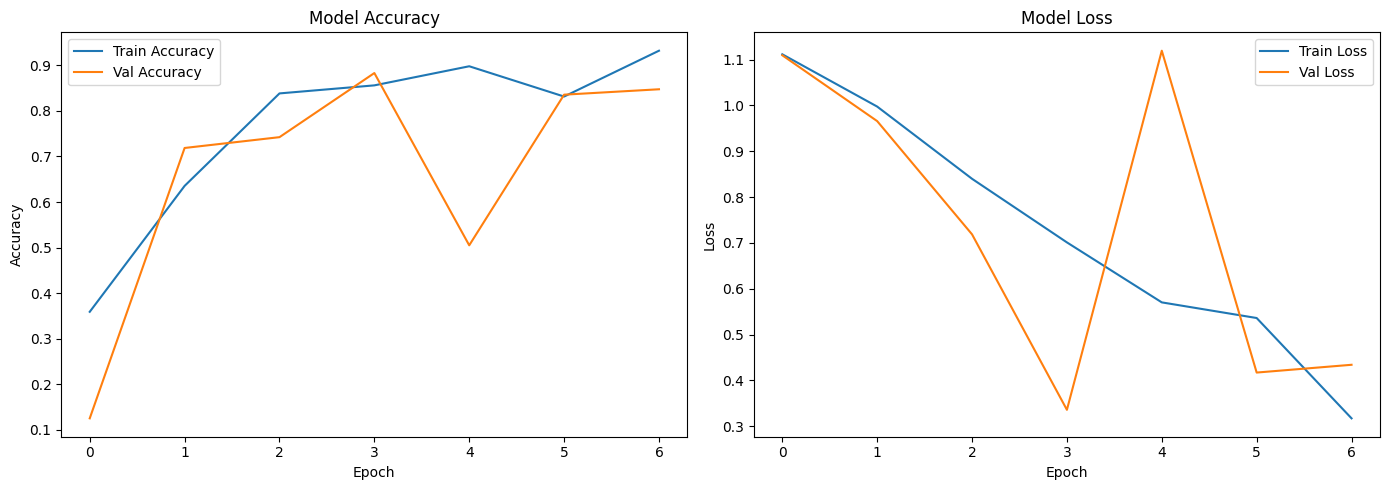

In [120]:
# Plot Training History
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history["accuracy"], label="Train Accuracy")
axes[0].plot(history.history["val_accuracy"], label="Val Accuracy")
axes[0].set_title("Model Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

# Loss
axes[1].plot(history.history["loss"], label="Train Loss")
axes[1].plot(history.history["val_loss"], label="Val Loss")
axes[1].set_title("Model Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.tight_layout()
plt.show()


In [121]:
# Evaluate the Model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("=" * 55)
print(" MODEL EVALUATION RESULTS")
print("=" * 55)
print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred_classes)*100:.2f}%")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step
 MODEL EVALUATION RESULTS

Test Accuracy: 88.50%

Classification Report:
              precision    recall  f1-score   support

    negative       0.49      0.64      0.56        56
     neutral       0.09      0.17      0.12        30
    positive       0.97      0.92      0.95       897

    accuracy                           0.89       983
   macro avg       0.52      0.58      0.54       983
weighted avg       0.91      0.89      0.90       983



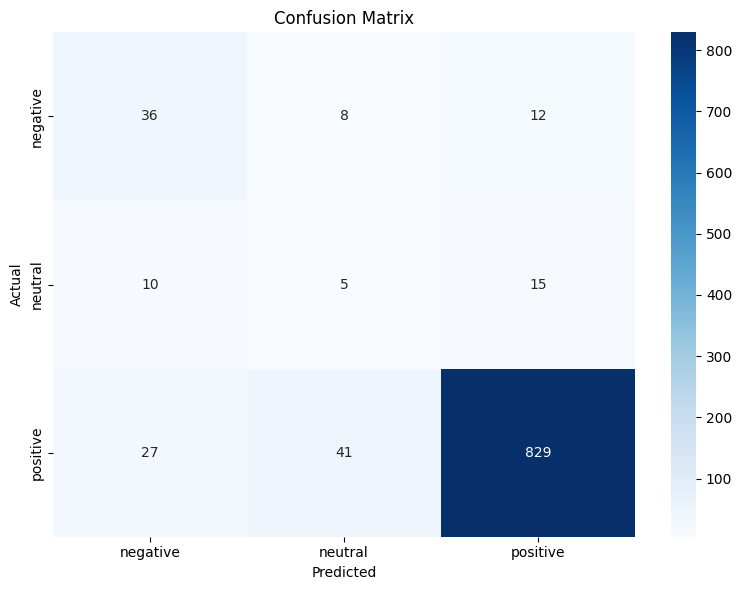

In [122]:
#  Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [123]:
# Test with Custom Input
def predict_sentiment(text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=MAX_LEN, padding="post", truncating="post")
    pred = model.predict(padded, verbose=0)
    label = le.classes_[np.argmax(pred)]
    confidence = np.max(pred) * 100
    print(f"Review : {text}")
    print(f"Sentiment : {label} ({confidence:.1f}% confidence)\n")

# Test examples
predict_sentiment("This product is amazing! Best purchase I ever made.")
predict_sentiment("this is a bad worst product i have ever bought. waste of money.")
predict_sentiment("It's okay, nothing special but does the job.")

Review : This product is amazing! Best purchase I ever made.
Sentiment : positive (95.7% confidence)

Review : this is a bad worst product i have ever bought. waste of money.
Sentiment : positive (61.0% confidence)

Review : It's okay, nothing special but does the job.
Sentiment : positive (77.6% confidence)



In [124]:
print("Before downsampling:")
print(dataset["sentiment"].value_counts())

# separate each class
df_positive = dataset[dataset["sentiment"] == "positive"]
df_neutral = dataset[dataset["sentiment"] == "neutral"]
df_negative = dataset[dataset["sentiment"] == "negative"]

Before downsampling:
sentiment
positive    4448
negative     324
neutral      142
Name: count, dtype: int64
